In [1]:
import numpy as np # NumPy
import matplotlib.pylab as plt # Matplotlib plots
import matplotlib.patches as mpatches
import pandas as pd # Pandas
import uproot
import pickle
import logging

import awkward as ak
import mplhep as hep
import argparse     # to get arguments from command line executing file.py
import os # read directories etc.
from scipy.signal import find_peaks, gaussian
from scipy.optimize import curve_fit
from scipy.stats import gaussian_kde
import pylandau
import re

from LoadBatch import *

verbose = False
debug = False

In [2]:
import ROOT

ModuleNotFoundError: No module named 'ROOT'

In [5]:
logging.basicConfig(level=logging.WARNING, format='[%(levelname)s] - at line %(lineno)d -\t %(message)s')

In [6]:
# Load the dataframe of sensor names
sensors_list = read_pickle("sensors_list.pickle")
if verbose: print(sensors_list)


# I wanna save data from both scopes
this_batch = 301
branches = ["Xtr", "Ytr", "pulseHeight", "charge", "timeCFD20", "timeCFD50", "timeCFD70"]

dir_path = {} 
df = {}  # dictionary containing the two dataframes of the two oscilloscopes
for S in ["S1","S2"]: # the two scopes
    dir_path[S] = f"../Data_TestBeam/2023_May/{S}/"
    file_path = f"tree_May2023_{S}_{this_batch}.root"
    df[S] = root_to_df(os.path.join(dir_path[S], file_path), branches)


['MCP', 'USTC2.1-W17-P6-A', 'USTC2.1-W17-P6-A', 'IMEv3-W12-C3-1-4']


Text(0.5, 1.0, 'Single sensor time distribution with pulseheight cut, batch:301 (CFD70)')

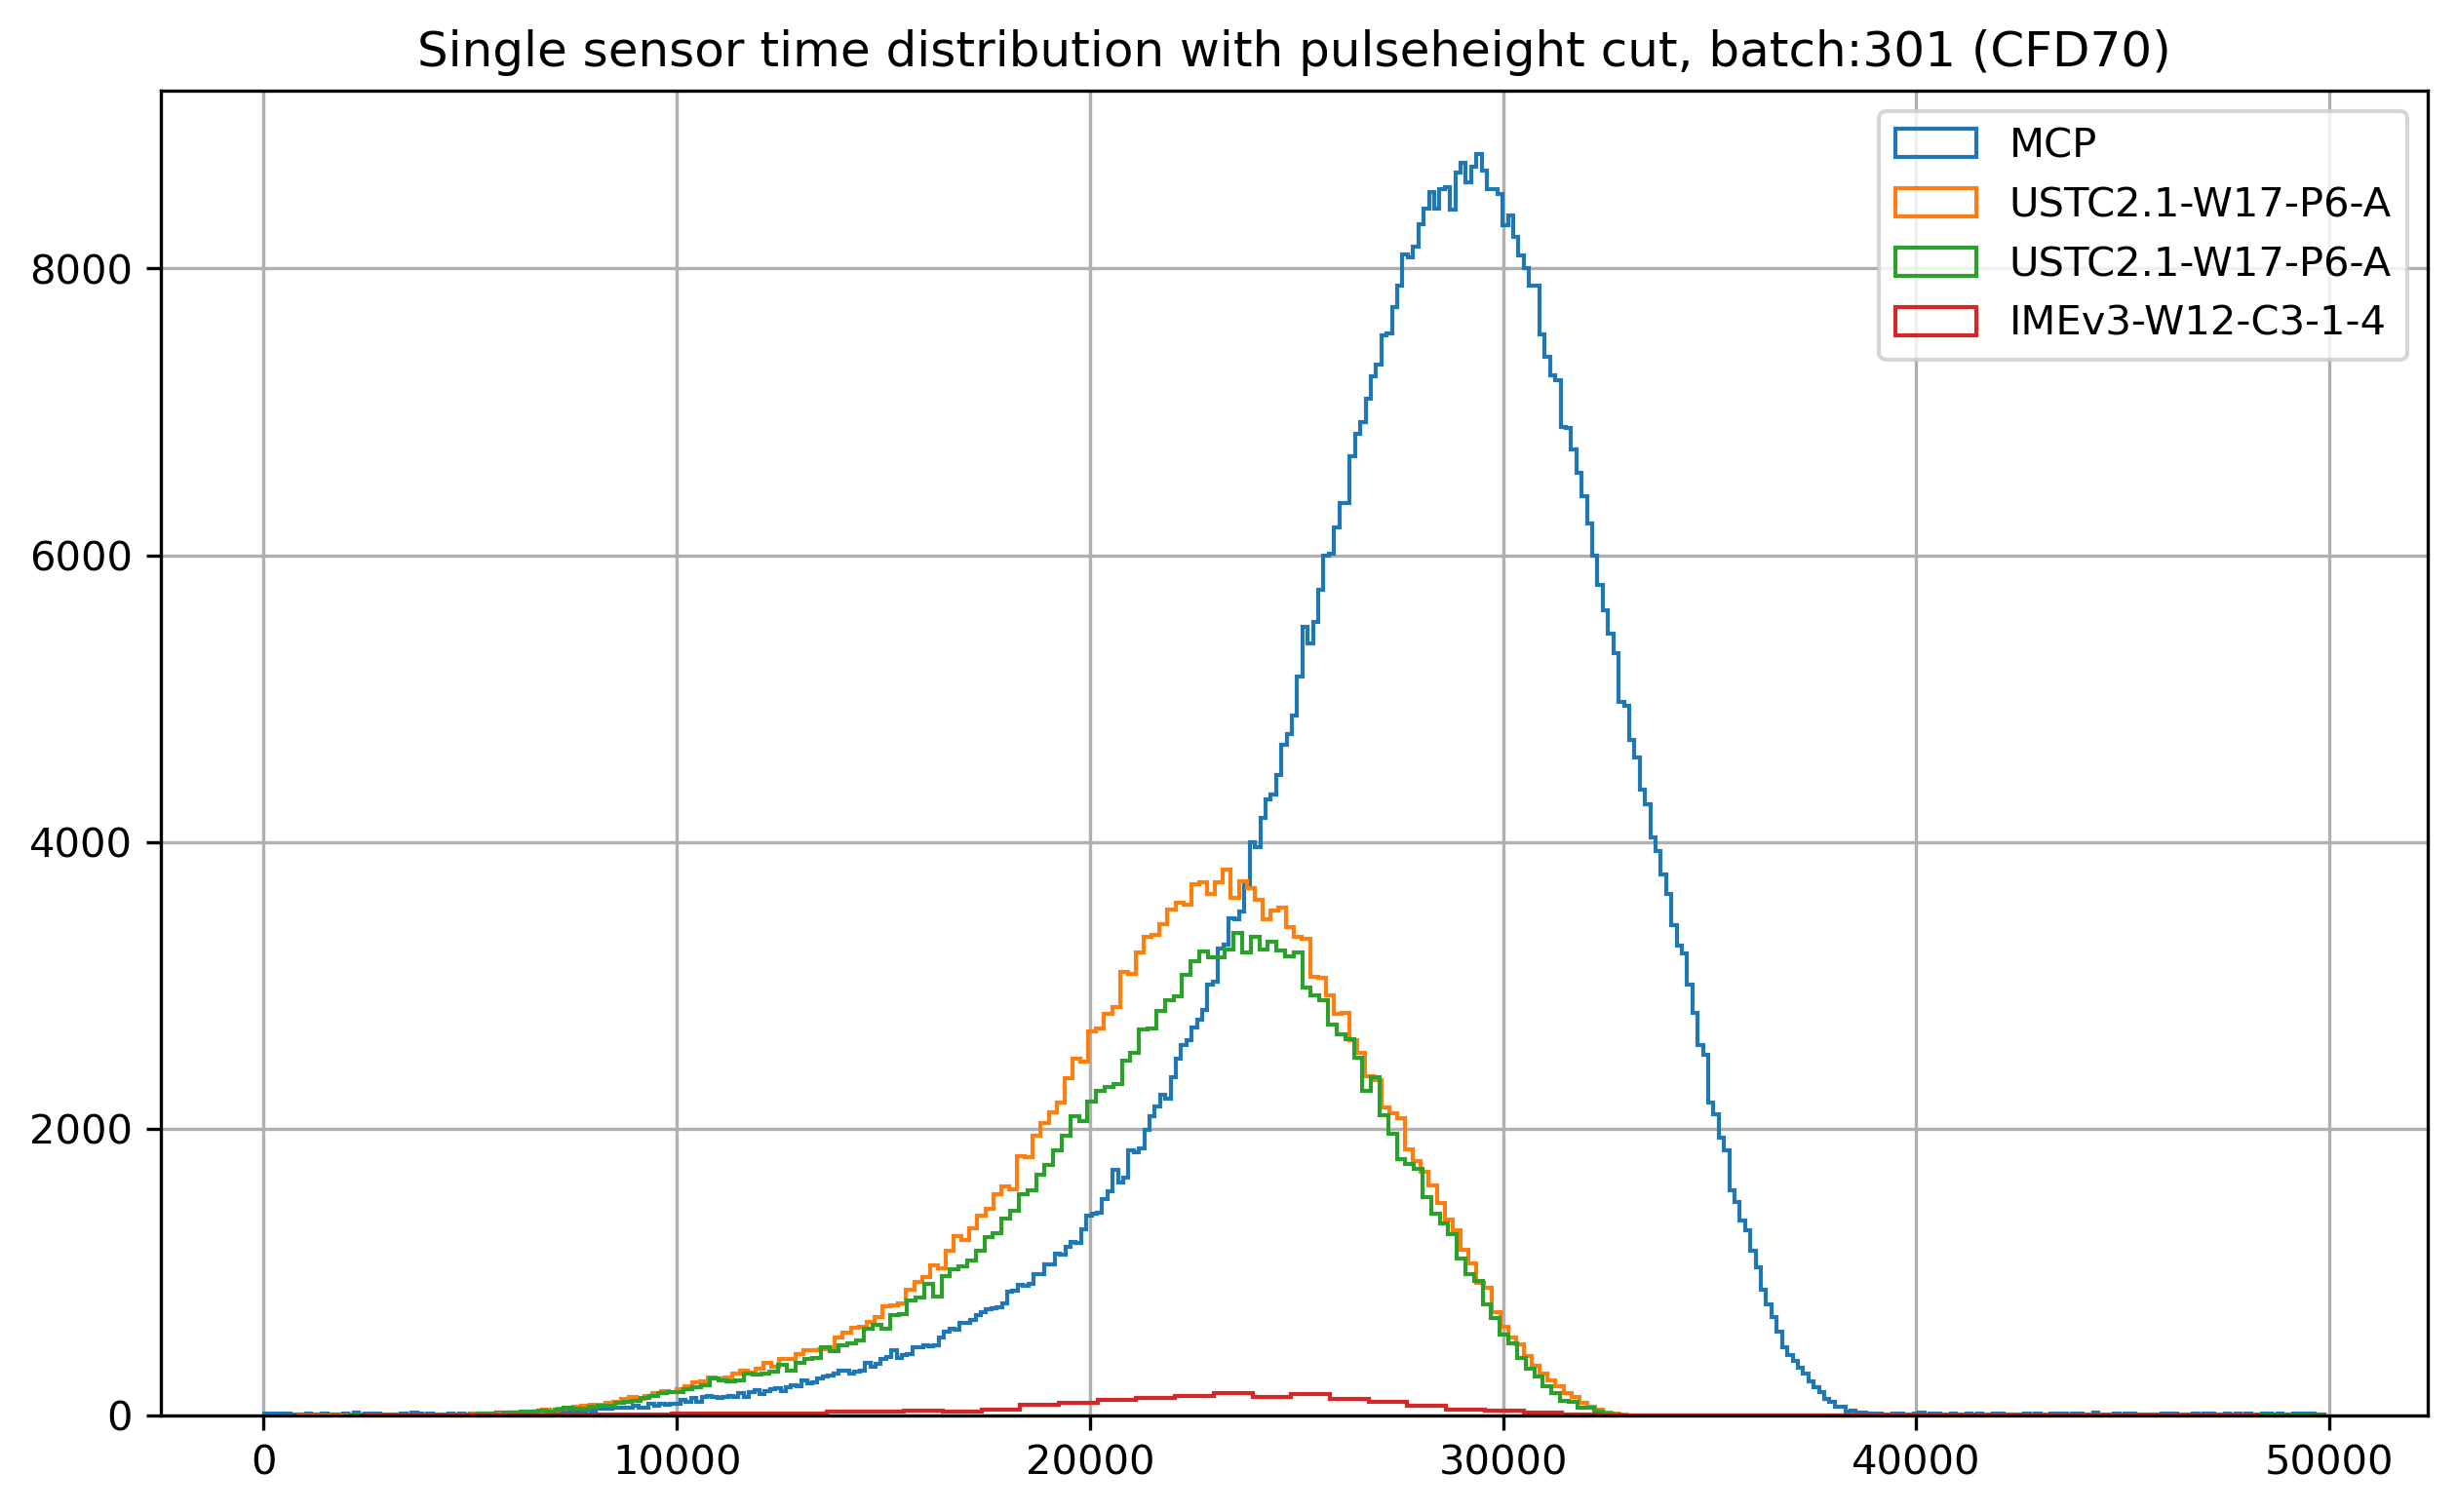

In [7]:
# Get the sensors names
this_scope = "S1"
these_sensors = list(sensors_list[this_batch][this_scope].values())
print(these_sensors)
CFD = 70
pulseheight_cut = [21.2, 18.5, 9.5]  #these values are still quite approximate

# Plot the time of constant fraction discriminator (50%)
_,_,_,fig, ax = plot_histogram(df[this_scope][f"timeCFD{CFD}_0"], label=these_sensors[0])
for i in range(1,4):
    plot_histogram(df[this_scope][f"timeCFD{CFD}_{i}"].loc[df[this_scope][f"pulseHeight_{i}"]>pulseheight_cut[i-1]], label=these_sensors[i], fig_ax=(fig,ax))
ax.legend()
ax.set_title(f"Single sensor time distribution with pulseheight cut, batch:{this_batch} (CFD{CFD})")

# fig.savefig(f"various plots/single_time_with_cut_res_batch{this_batch}_CDF{CFD}.jpg")

ValueError: too many values to unpack (expected 2)

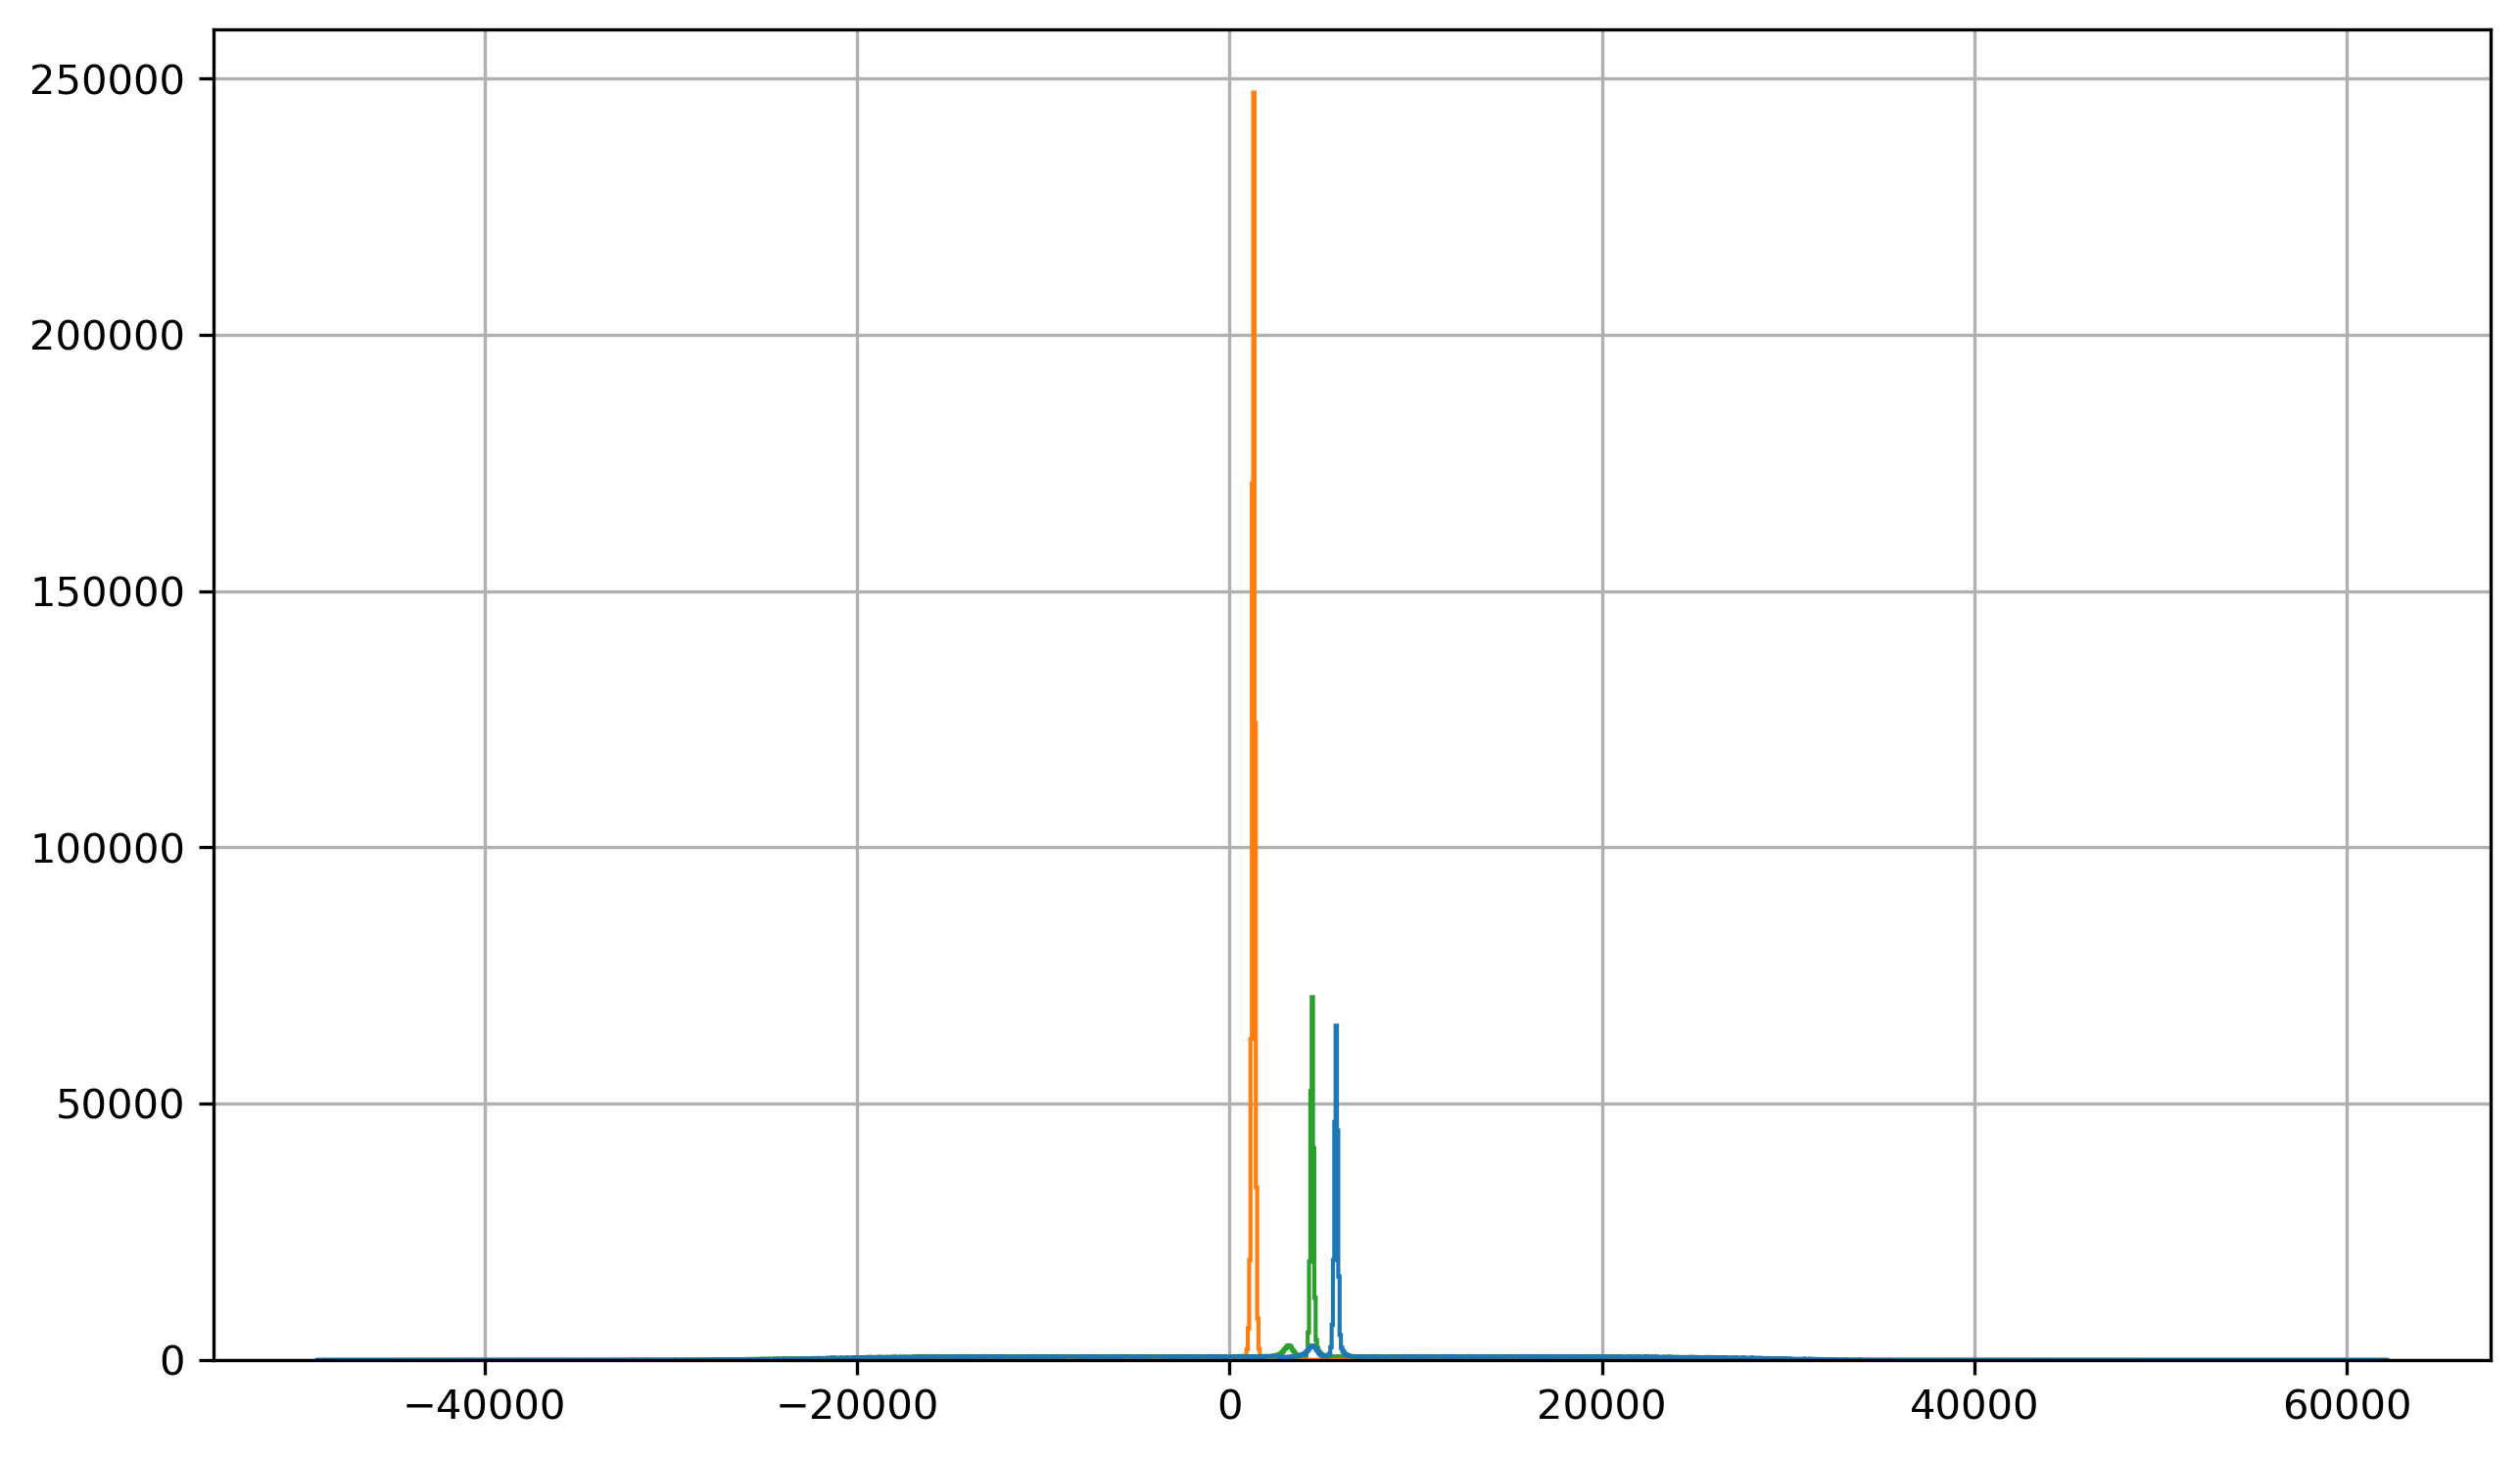

In [8]:
# plot the time of MCP for S1 and S2

#I NEED TO CHECK THE EVENT NUMBER FOR THE TWO OSCILLOSCOPES
t_1 = df['S1']['timeCFD20_0']
t_3 = df['S1']['timeCFD20_1']
t_4 = df['S2']['timeCFD20_0']
labels = (f"{sensors_list[this_batch]['S1']['Ch1']}(S1) - {sensors_list[this_batch]['S1']['Ch2']}", \
         f"{sensors_list[this_batch]['S1']['Ch1']}(S1) - {sensors_list[this_batch]['S2']['Ch1']}(S2)", \
         f"{sensors_list[this_batch]['S2']['Ch1']}(S2) - {sensors_list[this_batch]['S1']['Ch2']}")
these_sensors = sensors_list[this_batch]
fig, ax = plot_histogram((t_1-t_3, t_1-t_4, t_4-t_3 ),
                         label=labels)
ax.set_xlim(0,1e4)

ax.legend()

ValueError: too many values to unpack (expected 2)

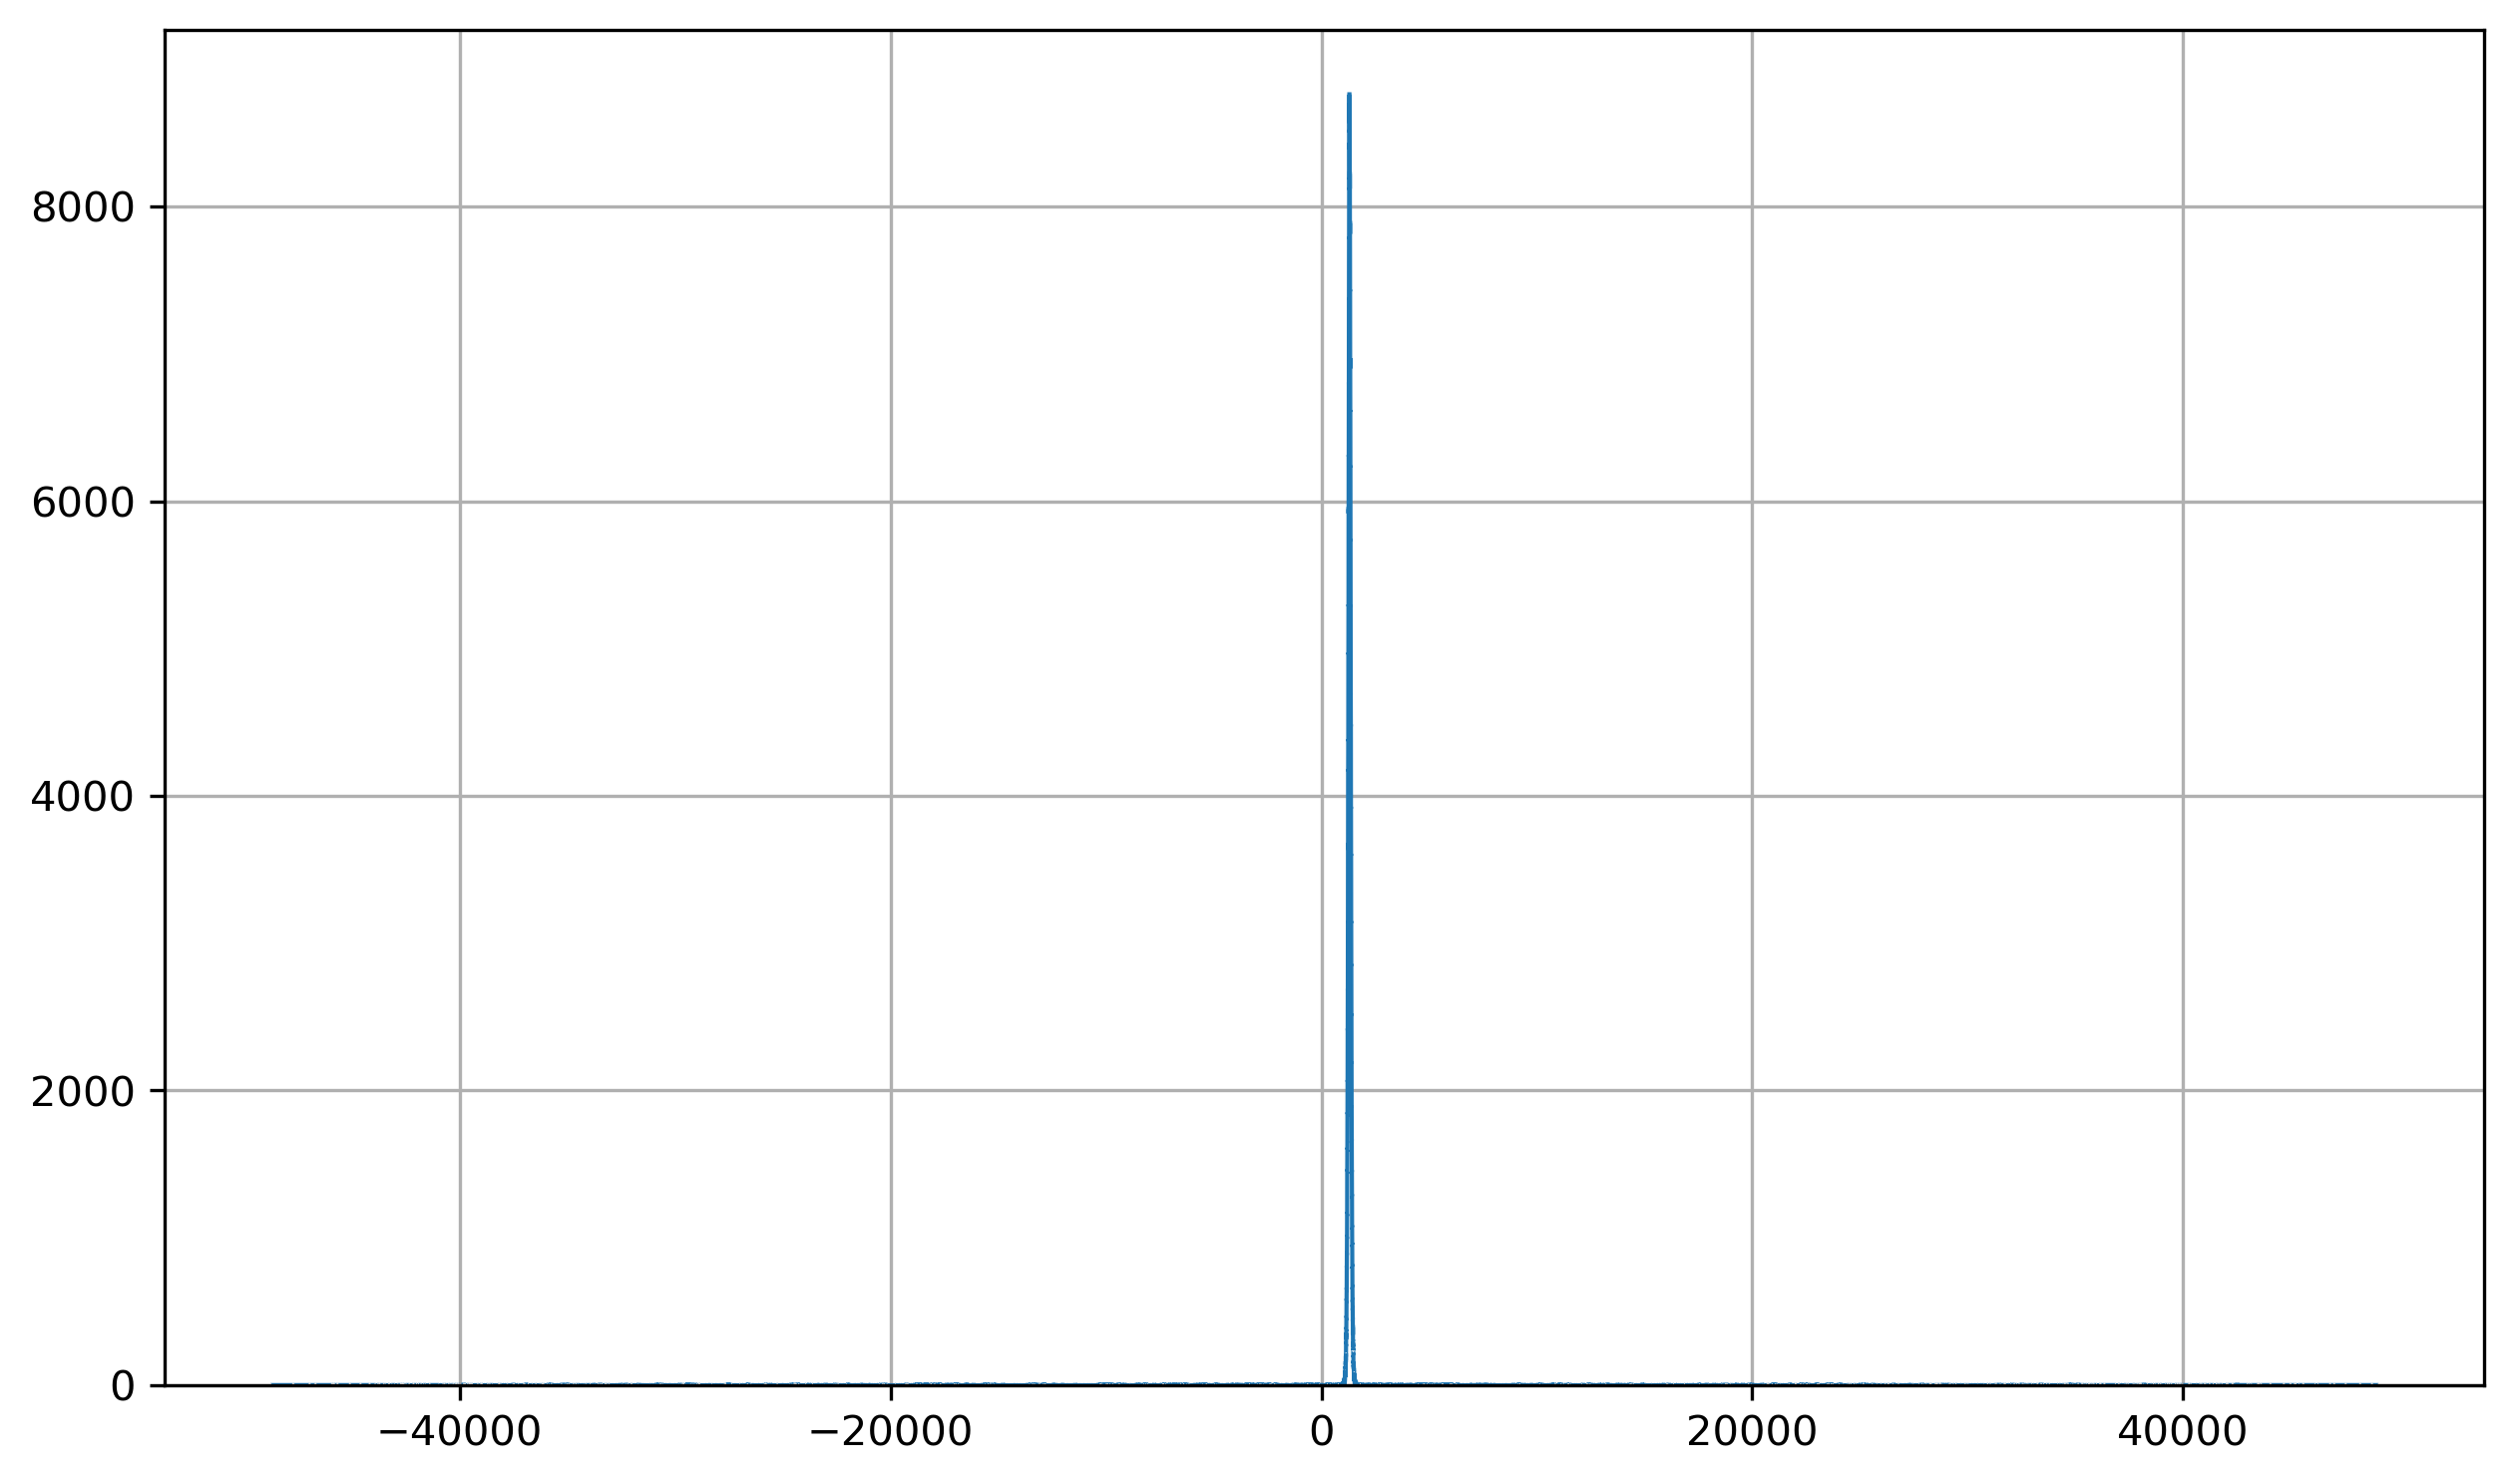

In [10]:
fig, ax = plot_histogram(df["S1"]["timeCFD70_0"]-df["S2"]["timeCFD70_0"])
ax

In [ ]:
# Plot the time of constant fraction discriminator (50%)
fig, ax = plot_histogram(df[f"timeCFD{CFD}_0"], label=these_sensors[0])
for i in [1,2,3]:
    add_histogram(ax, df[f"timeCFD{CFD}_{i}"], label=these_sensors[i])
ax.legend()
ax.set_title(f"Single sensor time distribution no pulseheight cut, batch:{this_batch} (CFD{CFD})")

fig.savefig(f"various plots/single_time_no_cut_res_batch{this_batch}_CDF{CFD}.jpg")

In [11]:
bins = 'auto'
fig, ax = plot_histogram(df[f"timeCFD{CFD}_1"].iloc[np.where(df[f"pulseHeight_1"]>pulseheight_cut[0])]-df[f"timeCFD{CFD}_2"].iloc[np.where(df[f"pulseHeight_2"]>pulseheight_cut[1])], bins=bins, label=f"Ch2 - Ch3")
add_histogram(ax, df[f"timeCFD{CFD}_1"].iloc[np.where(df[f"pulseHeight_1"]>pulseheight_cut[0])]-df[f"timeCFD{CFD}_3"].iloc[np.where(df[f"pulseHeight_3"]>pulseheight_cut[2])], bins=bins, label=f"Ch2 - Ch4")
add_histogram(ax, df[f"timeCFD{CFD}_2"].iloc[np.where(df[f"pulseHeight_2"]>pulseheight_cut[1])]-df[f"timeCFD{CFD}_3"].iloc[np.where(df[f"pulseHeight_3"]>pulseheight_cut[2])], bins=bins, label=f"Ch3 - Ch4")
ax.set_xlim(-1000, 1000)
ax.legend()
# df["timeCFD50_0"] - df["timeCFD50_2"]
ax.set_title(f"Combined sensors time distribution with pulseheight cut, batch:{this_batch} (CFD{CFD})")
fig.savefig(f"various plots/combined_time_res{this_batch}_CDF{CFD}.jpg")

KeyError: 'timeCFD70_1'